# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Classificação-de-Textos" data-toc-modified-id="Classificação-de-Textos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classificação de Textos</a></div><div class="lev2 toc-item"><a href="#Preâmbulo" data-toc-modified-id="Preâmbulo-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preâmbulo</a></div><div class="lev2 toc-item"><a href="#Procedimentos-de-treino-e-teste" data-toc-modified-id="Procedimentos-de-treino-e-teste-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Procedimentos de treino e teste</a></div><div class="lev2 toc-item"><a href="#O-Dataset" data-toc-modified-id="O-Dataset-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>O Dataset</a></div><div class="lev3 toc-item"><a href="#Criando--geradores-para-treino-e-validação" data-toc-modified-id="Criando--geradores-para-treino-e-validação-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Criando  geradores para treino e validação</a></div><div class="lev3 toc-item"><a href="#Lendo-do-disco" data-toc-modified-id="Lendo-do-disco-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Lendo do disco</a></div><div class="lev2 toc-item"><a href="#A-Rede-Neural" data-toc-modified-id="A-Rede-Neural-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>A Rede Neural</a></div><div class="lev3 toc-item"><a href="#Preparando-a-matriz-de-embeddings" data-toc-modified-id="Preparando-a-matriz-de-embeddings-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Preparando a matriz de embeddings</a></div><div class="lev3 toc-item"><a href="#Construindo-a-rede" data-toc-modified-id="Construindo-a-rede-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Construindo a rede</a></div><div class="lev2 toc-item"><a href="#Treinando" data-toc-modified-id="Treinando-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Treinando</a></div><div class="lev2 toc-item"><a href="#Avaliando" data-toc-modified-id="Avaliando-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Avaliando</a></div>

# Classificação de Textos

## Preâmbulo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import glob
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Procedimentos de treino e teste

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, train_generator, validation_generator, 
                  train_steps=10, valid_steps=10, opt='rmsprop', nepochs=50, 
                  patience=50, reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs of {} steps each...".format(tr_epochs, train_steps))
    try:
        model.fit_generator(train_generator, steps_per_epoch=train_steps,
                            validation_data=validation_generator, validation_steps=valid_steps,
                            epochs=nepochs, verbose=vv, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, validation_generator, nb_validation_samples):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## O Dataset

### Criando  geradores para treino e validação

In [4]:
class MyDataGenerator:
    def __init__(self, batch_size, seq_size, sequences, labels):
        self.batch_size = batch_size
        self.length = seq_size
        self.sequences = sequences
        self.labels = labels
        sizes = np.array([len(seq) for seq in sequences])
        self.p = 1.0 * sizes / sizes.sum()        # probabilidade de escolha para cada sequencia
        self.n = np.arange(len(sequences))        # indices de cada sequencia (para o choice abaixo)
        
    def __call__(self):
        while True:
            batch = np.empty((self.batch_size, self.length), np.int32)
            label = np.empty((self.batch_size, n_labels), np.int32)
            for i in range(self.batch_size):
                k = nr.choice(self.n, p=self.p)
                p = nr.randint(0, len(self.sequences[k]) - self.length)
                batch[i] = self.sequences[k][p:p+self.length]
                label[i] = to_categorical(self.labels[k], num_classes=n_labels)
            yield batch, label


### Lendo do disco

In [5]:
import pickle
train_gen, valid_gen, i2w = pickle.load(open('../../datasets/livros_generators.pkl', 'rb'))
print('Vocabulary: {} words'.format(len(i2w)))


Vocabulary: 20000 words


## A Rede Neural

### Preparando a matriz de embeddings

Neste notebook o embedding é treinado a partir de pesos aleatórios.


In [6]:
nr.seed(20170601)
EMBEDDING_DIM = 300
embeddings_index = {}

# prepare embedding matrix
num_words = len(i2w)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for i in range(1, num_words):
    embedding_vector = nr.random(size=(EMBEDDING_DIM,)) - 0.5
    embedding_matrix[i] = embedding_vector

seq_size = train_gen.length
n_labels = max(train_gen.labels) + 1
n_train_words = sum([len(x) for x in train_gen.sequences])
n_valid_words = sum([len(x) for x in valid_gen.sequences])
batch_size = train_gen.batch_size

print(embedding_matrix.shape)

(20000, 300)


### Construindo a rede

In [7]:
model_name = '../../models/livros_classif_1'

def build_net(embedding_matrix=None, input_len=None, trainable=True):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)

    x = Dropout(0.5)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    preds = Dense(n_labels, activation='softmax')(x)

    model = Model(seq_input, preds)
    return model

model = build_net(embedding_matrix, seq_size, True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 47, 128)           0         
__________

## Treinando

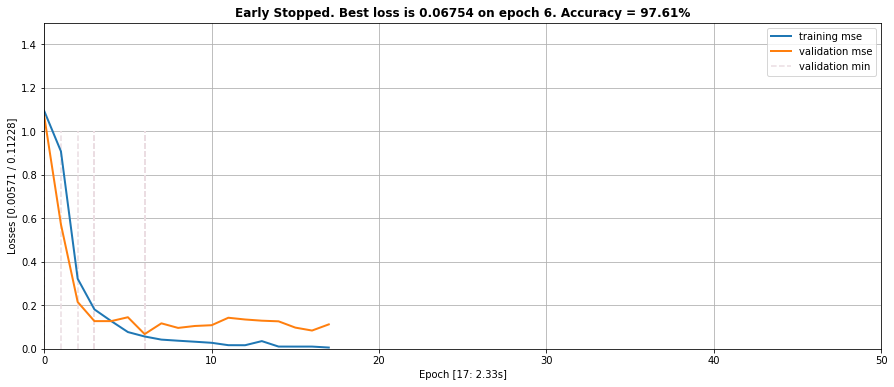

In [8]:
train_steps = n_train_words // (batch_size * seq_size)
valid_steps = n_valid_words // (batch_size * seq_size)

fit_params = {
    'train_steps':     train_steps,
    'valid_steps':     valid_steps,
    'opt':             Adam(0.0001),      #SGD(lr=0.001, momentum=0.9, nesterov=True), 
    'nepochs':         50,
    'patience':        10,
    'ploss':           1.5,
    'reset':           True,
}

train_network(model, model_name, train_gen(), valid_gen(), **fit_params);

## Avaliando

In [9]:
test_network(model_name, valid_gen(), valid_steps)

Model from epoch 6
[INFO] evaluating in the test data set ...

[INFO] accuracy on the test data set: 96.69% [0.09698]
